In [1]:
!pip install -q numpy pandas matplotlib statsmodels scipy tables h5py osparc_filecomms

In [2]:
import pathlib as pl
import uuid
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import pandas
import h5py
from osparc_filecomms import handshakers

In [3]:
POLLING_INTERVAL=0.1
INPUT_SAMPLE_SIZE = 100
SAMPLE_SIZE = 20
SEED = 500
INPUT_MUS = [1.0, 50.0, 100.0]
INPUT_SIGMAS = [1.0, 5.0, 10.0]
NOISE_MUS = [0.0, 0.0]
NOISE_SIGMAS = [5.0, 10.0]
VAR_NAMES = ["X0", "X1", "X2"]
RESPONSE_NAMES = ["Y0", "Y1"]
MIN_X = -10
MAX_X = 150
DX=5
X_RANGE=range(MIN_X, MAX_X, DX)

In [4]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

output_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_OUTPUTS'])
output1_dir_path = output_dir_path / 'output_1'

input_dir_path = pl.Path(os.environ['DY_SIDECAR_PATH_INPUTS'])
input1_dir_path = input_dir_path / 'input_1'

dakota_conf_path = output1_dir_path / 'dakota.in'

In [5]:
def clean_output(dir_path):                                                                                                                                                                 
        for item in dir_path.iterdir():                                                                                                                                                               
            if item.is_dir():                                                                                                                                                                         
                shutil.rmtree(item)                                                                                                                                                                   
            else:                                                                                                                                                                                     
                item.unlink()      
clean_output(output1_dir_path)

In [6]:
def plot_hists(inputs, expected_params=None, suptitle=None):
    if expected_params is None:
        expected_params = [[0,1] for _ in range(len(inputs))]
    n_of_inputs = len(inputs)
    fig, axes = plt.subplots(1,n_of_inputs, figsize=(12,5))

    for input, ax, (expected_mu, expected_sigma) in zip(inputs, axes, expected_params):
        _, x, _ = ax.hist(input, bins=X_RANGE, density=True)
        ax.plot(x, scipy.stats.norm.pdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', label='theoretical')
        ax.axvline(input.mean(), color='k', linestyle='dashed', linewidth=1)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_ylabel("density")
        ax.legend()

    
    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [7]:
def plot_cdfs(datas, expected_params, suptitle=None):
    n_of_inputs = len(datas)
    fig, axes = plt.subplots(1,n_of_inputs, figsize=(12,5))

    for data, (expected_mu, expected_sigma), ax in zip(datas, expected_params, axes):
        counts, bins = np.histogram(data, bins=X_RANGE, density=True)
        x = bins[1:]
        pdf = counts/sum(counts)
        cdf = np.cumsum(pdf)
        ax.plot(x, cdf, 'o', label='data')
        ax.plot(x, scipy.stats.norm.cdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical', alpha=0.5)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_ylabel("fraction")
        ax.legend()
    
    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [8]:
def plot_qq(datas, expected_params, suptitle=None):
    fig, axes = plt.subplots(1,len(datas), figsize=(12,5))

    for data, (expected_mu, expected_sigma), ax in zip(datas, expected_params, axes):
        sm.qqplot(data,  scipy.stats.norm, loc=expected_mu, scale=expected_sigma, ax=ax,line="45")

    fig.suptitle(suptitle) 
    plt.tight_layout()
    plt.show()

In [9]:
def generate_inputs(mus=INPUT_MUS, sigmas=INPUT_SIGMAS):
    np.random.seed(SEED)
    gaussians = []
    for mu, sigma in zip(mus, sigmas):
        gaussians.append(np.random.normal(mu, sigma, size=INPUT_SAMPLE_SIZE))

    return gaussians

inputs = generate_inputs()

In [10]:
def model_batch(inputs, mus=NOISE_MUS, sigmas=NOISE_SIGMAS):
    np.random.seed(SEED+1)
    outputs = [[] for _ in range(2)]
    gauss_noise0 = np.random.normal(mus[0], sigmas[0], size=SAMPLE_SIZE)
    gauss_noise1 = np.random.normal(mus[1], sigmas[1], size=SAMPLE_SIZE)
    outputs[0] = inputs[0] + inputs[1] + gauss_noise0
    outputs[1] = inputs[2] + gauss_noise1
    return outputs

def model(input, mus=NOISE_MUS, sigmas=NOISE_SIGMAS):
    x0, x1, x2 = input
    noise0 = np.random.normal(mus[0], sigmas[0])
    noise1 = np.random.normal(mus[1], sigmas[1])
    y0 = x0 + x1 + noise0
    y1 = x2 + noise1
    return y0, y1

In [11]:
outputs = model_batch([np.random.choice(input, SAMPLE_SIZE) for input in inputs])

In [12]:
expected_output_mus = np.zeros(2)
expected_output_sigmas = np.zeros(2)

expected_output_mus[0] = INPUT_MUS[0] + INPUT_MUS[1] + NOISE_MUS[0]
expected_output_mus[1] = INPUT_MUS[2] + NOISE_MUS[1]

expected_output_sigmas[0] = math.sqrt(math.pow(INPUT_SIGMAS[0],2.0) + math.pow(INPUT_SIGMAS[1],2.0) + math.pow(NOISE_SIGMAS[0],2.0))
expected_output_sigmas[1] = math.sqrt(math.pow(INPUT_SIGMAS[2],2.0) + math.pow(NOISE_SIGMAS[1],2.0))
print(expected_output_mus)
print(expected_output_sigmas)

[ 51. 100.]
[ 7.14142843 14.14213562]


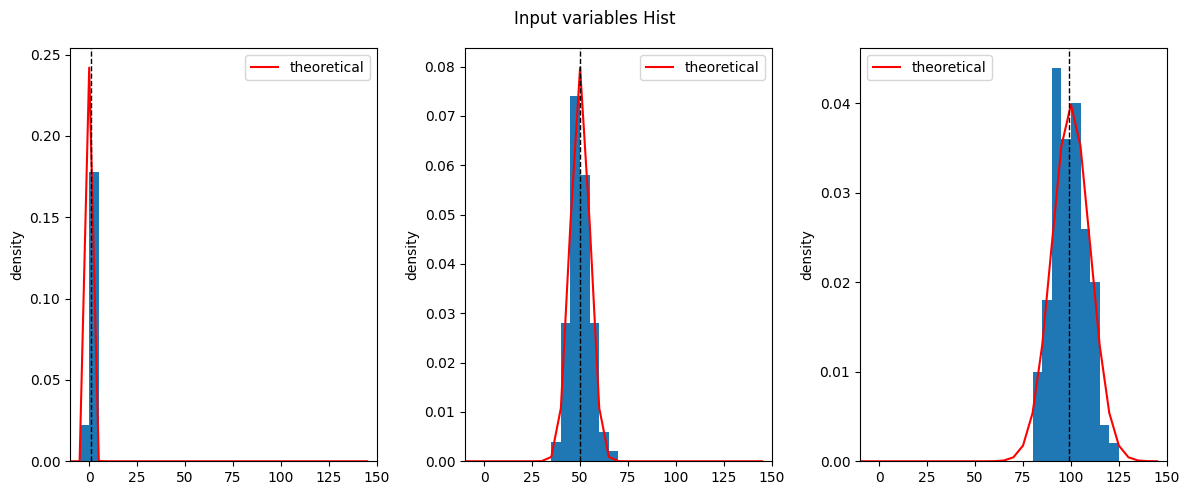

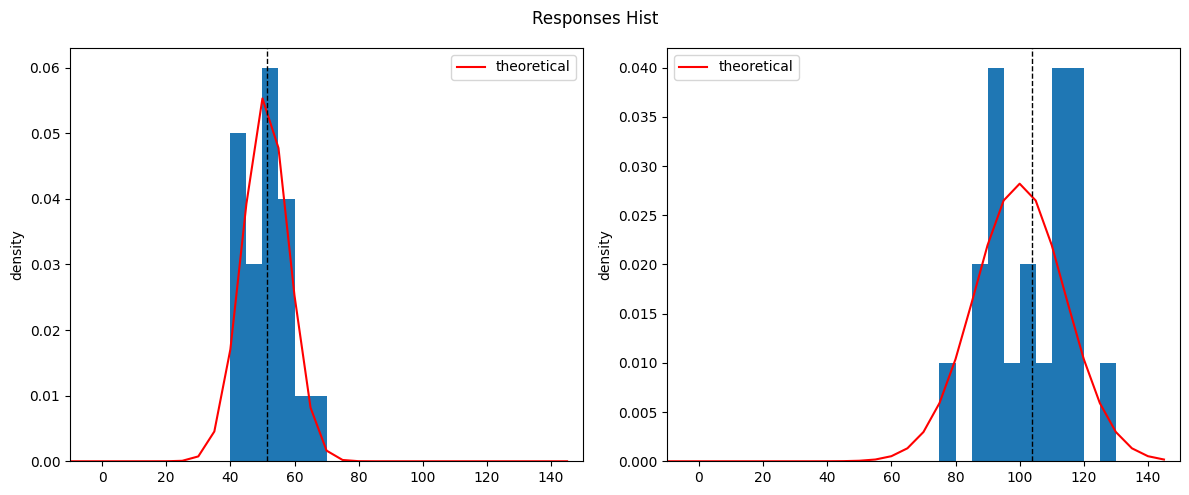

In [13]:
plot_hists(inputs, expected_params=zip(INPUT_MUS, INPUT_SIGMAS), suptitle='Input variables Hist')
plot_hists(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Responses Hist')

In [14]:
inputs_counts_bins = [np.histogram(input, bins='auto') for input in inputs]
inputs_counts_bins = [(np.concatenate((counts,np.array([0]))), bins) for counts, bins in inputs_counts_bins]

In [15]:
def create_dakota_conf():
    response_levels = " ".join(str(number) for number in X_RANGE)
    response_descriptors = " ".join(f'"{response_name}"' for response_name in RESPONSE_NAMES)
    var_descriptors = " ".join(f'"{var_name}"' for var_name in VAR_NAMES)
    var_counts = "\t".join(" ".join([str(count) for count in counts]) for counts, _ in inputs_counts_bins)
    var_bins = "\t".join(" ".join([str(bin) for bin in bins]) for _, bins in inputs_counts_bins)
    var_pairs_per_var = "\t".join(str(len(counts)) for counts, _ in inputs_counts_bins)
    dakota_conf = f"""
environment
  tabular_data
    tabular_data_file = 'uq_sampling.dat'
  results_output
    hdf5
    results_output_file
      "dakota_results"
  top_method_pointer = 'UQ'
  

method
  id_method = 'UQ'
  sampling
    sample_type lhs
    samples = {SAMPLE_SIZE}
    seed = 12345
    output = silent
    response_levels = 
        {response_levels}
        {response_levels}
 
variables
  histogram_bin_uncertain = 3
    pairs_per_variable = {var_pairs_per_var}
    abscissas = {var_bins}
    counts = {var_counts}
    descriptors = {var_descriptors}
    
responses
  response_functions = 2
  descriptors = {response_descriptors}
  no_gradients
  no_hessians

interface
  id_interface = 'TRUTH_MODEL'
  analysis_drivers = 'model'
    batch
    python
"""
    return dakota_conf

In [16]:
dakota_conf = create_dakota_conf()
print(dakota_conf)


environment
  tabular_data
    tabular_data_file = 'uq_sampling.dat'
  results_output
    hdf5
    results_output_file
      "dakota_results"
  top_method_pointer = 'UQ'
  

method
  id_method = 'UQ'
  sampling
    sample_type lhs
    samples = 20
    seed = 12345
    output = silent
    response_levels = 
        -10 -5 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145
        -10 -5 0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145
 
variables
  histogram_bin_uncertain = 3
    pairs_per_variable = 9	12	9
    abscissas = -1.0890663586299687 -0.5857946364443938 -0.08252291425881886 0.42074880792675606 0.924020530112331 1.4272922522979061 1.9305639744834808 2.4338356966690555 2.937107418854631	36.05201998928341 38.691310448664765 41.330600908046115 43.96989136742747 46.60918182680882 49.24847228619018 51.887762745571536 54.52705320495289 57.16634366433424 59.80563412371559 62.44492458309695 

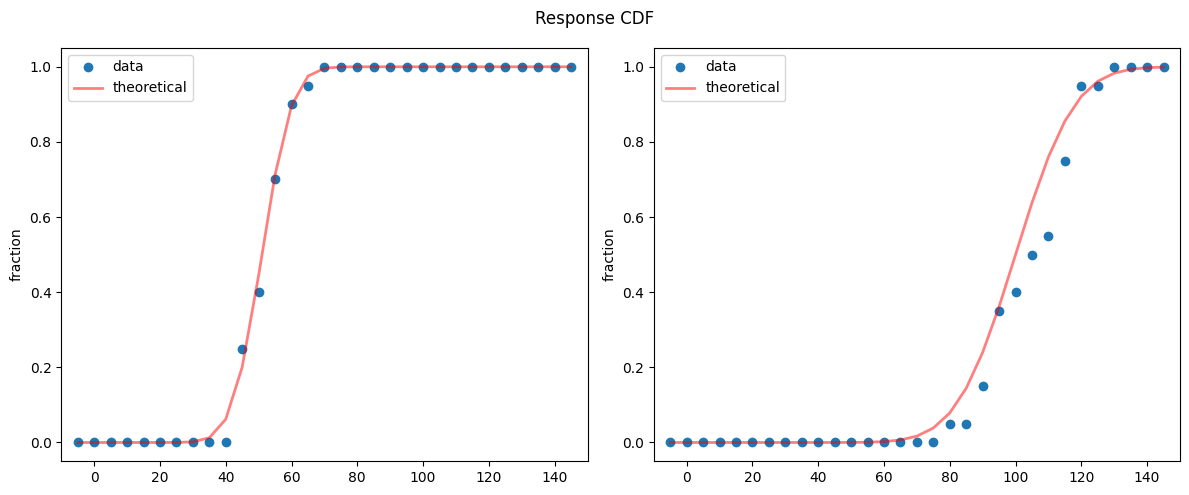

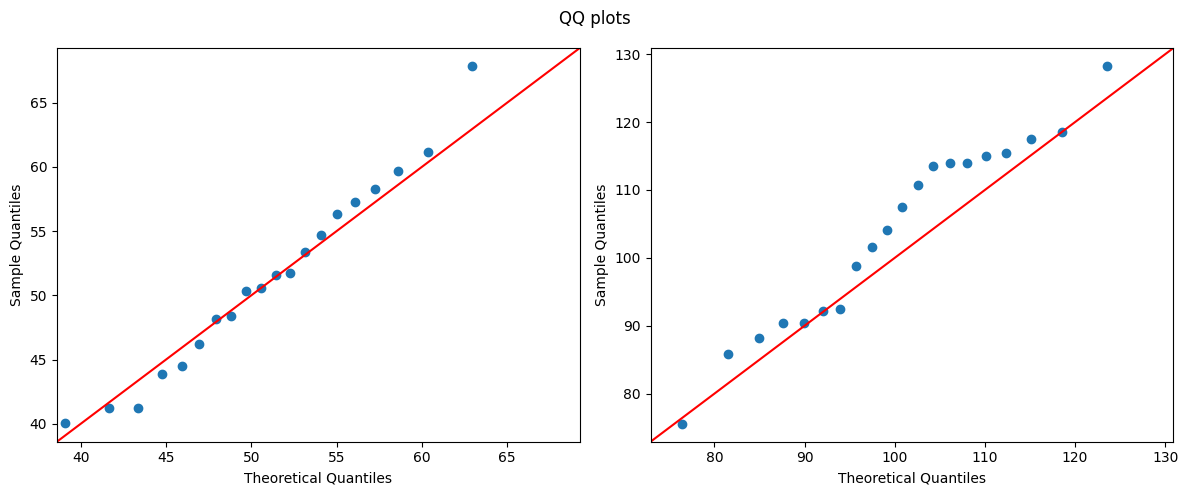

In [17]:
plot_cdfs(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Response CDF')
plot_qq(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='QQ plots')

In [18]:
my_uuid = uuid.uuid4()
dakota_handshaker = handshakers.FileHandshaker(my_uuid, input1_dir_path, output1_dir_path)
dakota_handshaker.shake()

dakota_conf_path.write_text(dakota_conf);

In [19]:
def read_results(results_path):
    def h5_open_wait(h5file):    
        wait = 3
    
        while True:
            try:
                h5f = h5py.File(h5file,'r')
                return h5f
                    
            except FileNotFoundError:
                return None
            
            except OSError:
                time.sleep(wait) 
        h5f.close()
        
    h5_open_wait(results_path)
    with h5py.File(results_path,'r') as results_file:
        cdfs = {}
        for response_name in RESPONSE_NAMES:
            results = results_file[f"/methods/UQ/results/execution:1/response_levels/{response_name}"]
            cdfs[response_name] = results[:results.len()]

    return cdfs

In [20]:
results_path = input1_dir_path / 'dakota_results.h5'
while not results_path.exists():
    time.sleep(POLLING_INTERVAL)
dakota_cdfs = read_results(results_path)

In [21]:
def plot_dakota_pdfs(cdfs, expected_params, suptitle=None):
    fig, axes = plt.subplots(1, len(cdfs),figsize=(12,5))

    for (response_name, cdf), ax, (expected_mu, expected_sigma) in zip(cdfs.items(), axes, expected_params):
        x = X_RANGE
        pdf = np.diff(cdf, prepend=0)/DX
        ax.plot(x, scipy.stats.norm.pdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical')
        ax.bar(x, pdf, width=DX)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_xlabel(response_name)
        ax.set_ylabel("density")
        ax.legend()

    fig.suptitle(suptitle)
    fig.tight_layout()
    fig.show()

In [22]:
def plot_dakota_cdfs(cdfs, expected_params, suptitle=None):
    fig, axes = plt.subplots(1, len(cdfs),figsize=(12,5))

    for (response_name, cdf), ax, (expected_mu, expected_sigma) in zip(cdfs.items(), axes, expected_params):
        x = X_RANGE
        ax.plot(x, cdf, 'o', label='data')
        ax.plot(x, scipy.stats.norm.cdf(x = x, loc = expected_mu, scale = expected_sigma), 'r', linewidth=2, label='theoretical', alpha=0.5)
        ax.set_xlim(MIN_X,MAX_X)
        ax.set_xlabel(response_name)
        ax.set_ylabel("fraction")
        ax.legend()

    fig.suptitle(suptitle)
    fig.tight_layout()
    fig.show()

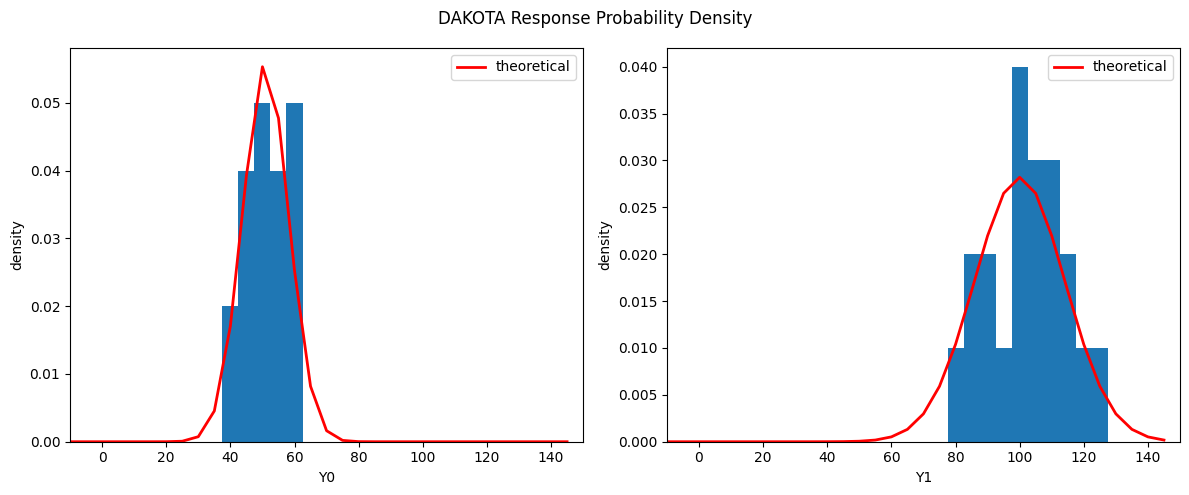

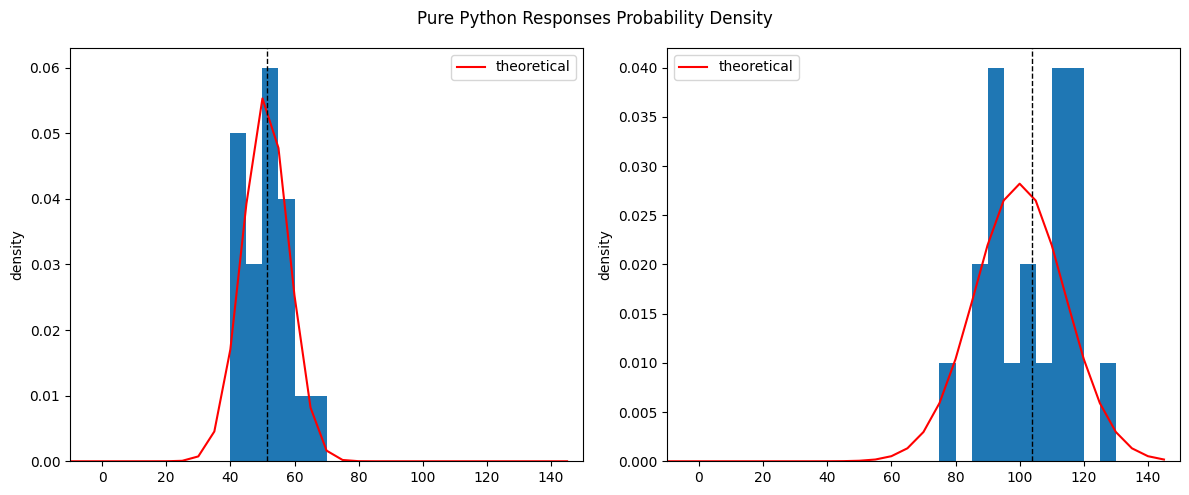

In [23]:
plot_dakota_pdfs(dakota_cdfs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='DAKOTA Response Probability Density')
plot_hists(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Pure Python Responses Probability Density')

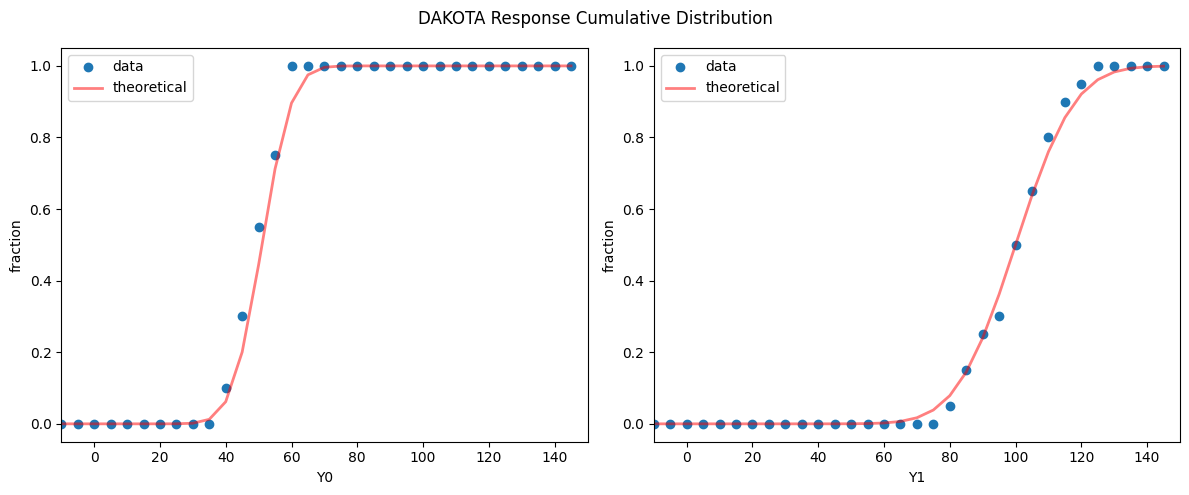

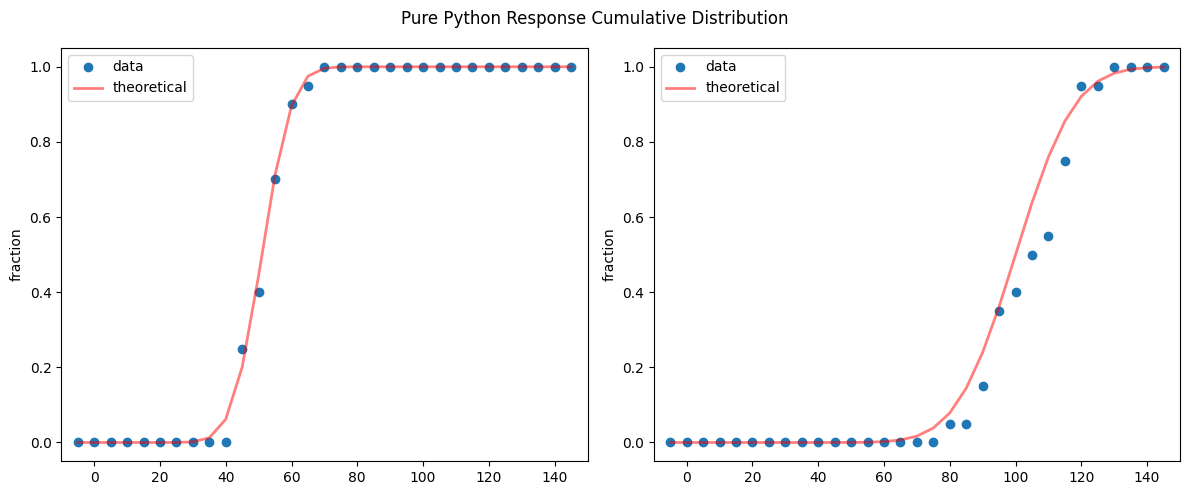

In [24]:
plot_dakota_cdfs(dakota_cdfs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='DAKOTA Response Cumulative Distribution')
plot_cdfs(outputs, expected_params=zip(expected_output_mus, expected_output_sigmas), suptitle='Pure Python Response Cumulative Distribution')